# Pip Installs, Import Packages, + Load Data

-   Install and load packages

-   Load Prem + event data

In [1]:
 %pip install tqdm statsbombpy pytorch-tabnet xgboost -q

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# General Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Specific imports for this data
from typing import Optional, Iterable
from statsbombpy import sb
from tqdm.auto import tqdm
import math

# Modeling imports
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# 2015/2016 Premier League Matches
Prem = sb.matches(competition_id=2, season_id=27)

# Print cols + head
print(Prem.columns)
Prem.sort_values(by='match_week', ascending=True).head()

Index(['match_id', 'match_date', 'kick_off', 'competition', 'season',
       'home_team', 'away_team', 'home_score', 'away_score', 'match_status',
       'match_status_360', 'last_updated', 'last_updated_360', 'match_week',
       'competition_stage', 'stadium', 'referee', 'home_managers',
       'away_managers', 'data_version', 'shot_fidelity_version',
       'xy_fidelity_version'],
      dtype='object')


,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,...,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version
379,3754078,2015-08-08,18:30:00.000,England - Premier League,2015/2016,Chelsea,Swansea City,2,2,available,...,2021-06-13T16:17:31.694,1,Regular Season,Stamford Bridge,Michael Oliver,José Mario Felix dos Santos Mourinho,Garry Monk,1.1.0,2,2
78,3754097,2015-08-08,13:45:00.000,England - Premier League,2015/2016,Manchester United,Tottenham Hotspur,1,0,available,...,2021-06-13T16:17:31.694,1,Regular Season,Old Trafford,Jonathan Moss,Louis van Gaal,Mauricio Roberto Pochettino Trossero,1.1.0,2,2
71,3754112,2015-08-09,14:30:00.000,England - Premier League,2015/2016,Newcastle United,Southampton,2,2,available,...,2021-06-13T16:17:31.694,1,Regular Season,St. James'' Park,Craig Pawson,Steve McClaren,Ronald Koeman,1.1.0,2,2
175,3754300,2015-08-08,16:00:00.000,England - Premier League,2015/2016,Everton,Watford,2,2,available,...,2021-06-13T16:17:31.694,1,Regular Season,Goodison Park,Mike Jones,Roberto Martínez Montoliú,Enrique Sánchez Flores,1.1.0,2,2
124,3754237,2015-08-08,16:00:00.000,England - Premier League,2015/2016,Leicester City,Sunderland,4,2,available,...,2021-06-13T16:17:31.694,1,Regular Season,King Power Stadium,Lee Mason,Claudio Ranieri,Dick Advocaat,1.1.0,2,2


In [4]:
# Intial empty lists 
all_events = [] # where match df and events df will be concatenated
failures = [] # for error handling if any matches fail

# Unique match IDs from Prem
match_ids = Prem["match_id"].dropna().astype(int).unique()

# For loop going through each match and fetching events
for mid in tqdm(match_ids, desc="Fetching events"):
    try:
        df = sb.events(match_id=mid) # Fetch events for the current match
        if df.empty:
            failures.append((mid, "No events returned")) # Track matches where StatsBomb returns no events
        else:
            df["match_id"] = mid # Add `match_id` column to keep track of which match this row belongs to
            all_events.append(df) # Append this match's events to the list
    except Exception as e:
        failures.append((mid, str(e))) # Track matches that raise an error during fetching


# Concat all match dataframes into one big DataFrame
if all_events:
    events_df = pd.concat(all_events, ignore_index=True)
    print(f"✅ Loaded {len(events_df):,} event rows from {len(all_events)} matches.")
else:
    events_df = pd.DataFrame()
    print("⚠️ No events were loaded.")

# Error handling
if failures:
    print(f"⚠️ Skipped {len(failures)} matches (showing first 5):")
    for mid, msg in failures[:5]:
        print(f"  - match_id={mid}: {msg}")


Fetching events:   0%|          | 0/380 [00:00<?, ?it/s]

✅ Loaded 1,313,783 event rows from 380 matches.


# Event Data Cleaning

-   Noticed quite a lot of dummy variables that make data hard to understand. Did some basic feature engineering for some columns and removed cols that I found not helpful for our usecase. Haven't fully worked through entire dataset because I moved onto selecting features we *need* rather than removing ones we don't. Maybe will come back to this.

-   In order to get a better understanding of different features I found a full prem match on YouTube. Match actually starts at 26:50 in the video. I subset the events df to get a look at this particular game later in this section.
    -   Leicester vs Everton 
    -   match_id = 3754033 
    -   url = https://archive.org/details/bpl-leicester-vs-everton-2015-2016


In [5]:
# Inspect Event Data Frame Head
pd.set_option('display.max_columns', None)
print(events_df.shape)

# Sort cols alphabetically
events_df = events_df[sorted(events_df.columns)]
events_df.head()

(1313783, 118)


,50_50,bad_behaviour_card,ball_receipt_outcome,ball_recovery_offensive,ball_recovery_recovery_failure,block_deflection,block_offensive,block_save_block,carry_end_location,clearance_aerial_won,clearance_body_part,clearance_head,clearance_left_foot,clearance_other,clearance_right_foot,counterpress,dribble_no_touch,dribble_nutmeg,dribble_outcome,dribble_overrun,duel_outcome,duel_type,duration,foul_committed_advantage,foul_committed_card,foul_committed_offensive,foul_committed_penalty,foul_committed_type,foul_won_advantage,foul_won_defensive,foul_won_penalty,goalkeeper_body_part,goalkeeper_end_location,goalkeeper_lost_in_play,goalkeeper_lost_out,goalkeeper_outcome,goalkeeper_penalty_saved_to_post,goalkeeper_position,goalkeeper_punched_out,goalkeeper_saved_to_post,goalkeeper_shot_saved_off_target,goalkeeper_shot_saved_to_post,goalkeeper_success_in_play,goalkeeper_technique,goalkeeper_type,half_start_late_video_start,id,index,injury_stoppage_in_chain,interception_outcome,location,match_id,minute,miscontrol_aerial_won,off_camera,out,pass_aerial_won,pass_angle,pass_assisted_shot_id,pass_body_part,pass_cross,pass_cut_back,pass_deflected,pass_end_location,pass_goal_assist,pass_height,pass_inswinging,pass_length,pass_miscommunication,pass_no_touch,pass_outcome,pass_outswinging,pass_recipient,pass_recipient_id,pass_shot_assist,pass_straight,pass_switch,pass_technique,pass_through_ball,pass_type,period,play_pattern,player,player_id,player_off_permanent,position,possession,possession_team,possession_team_id,related_events,second,shot_aerial_won,shot_body_part,shot_deflected,shot_end_location,shot_first_time,shot_follows_dribble,shot_freeze_frame,shot_key_pass_id,shot_one_on_one,shot_open_goal,shot_outcome,shot_redirect,shot_saved_off_target,shot_saved_to_post,shot_statsbomb_xg,shot_technique,shot_type,substitution_outcome,substitution_outcome_id,substitution_replacement,substitution_replacement_id,tactics,team,team_id,timestamp,type,under_pressure
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9153e9f4-f69c-4e04-8f64-505592e212cd,1,NaN,NaN,NaN,3754058,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Regular Play,NaN,NaN,NaN,NaN,1,Leicester City,22,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'formation': 442, 'lineup': [{'player': {'id'...",Leicester City,22,00:00:00.000,Starting XI,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3fbcf4e7-94d1-485a-be85-fd26a6af0318,2,NaN,NaN,NaN,3754058,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Regular Play,NaN,NaN,NaN,NaN,1,Leicester City,22,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'formation': 4141, 'lineup': [{'player': {'id...",AFC Bournemouth,28,00:00:00.000,Starting XI,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,06a9a4dc-d9c9-40f6-bd89-437ba7fe682d,3,NaN,NaN,NaN,3754058,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Regular Play,NaN,NaN,NaN,NaN,1,Leicester City,22,[100362ee-9311-4187-bd8a-0201d9db2565],0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AFC Bournemouth,28,00:00:00.000,Half Start,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100362ee-9311-4187-bd8a-0201d9db2565,4,NaN,NaN,NaN,3754058,0,NaN,NaN,NaN,

## Basic Feature Engineering

In [6]:
# Feature Engineering

# Combine all clearance-related columns into one boolean column — indicates whether *any* clearance occurred
events_df['clearance'] = events_df[['clearance_aerial_won', 'clearance_body_part', 'clearance_head', 'clearance_left_foot', 'clearance_other']].any(axis=1)

# Combine all block-related columns into one boolean column — indicates whether *any* block occurred
events_df['block'] = events_df[['block_deflection', 'block_offensive', 'block_save_block']].any(axis=1)

# Combine goalkeeper type and outcome into a single descriptive column
events_df['goalkeeper_type_outcome'] = events_df['goalkeeper_type'].astype(str) + ' - ' + events_df['goalkeeper_outcome'].astype(str)

# Replace True with descriptive string for fouls committed with advantage
events_df['foul_committed_advantage'] = events_df['foul_committed_advantage'].replace(True, 'Committed Advantage')

# Replace True with descriptive string for offensive fouls committed
events_df['foul_committed_offensive'] = events_df['foul_committed_offensive'].replace(True, 'Committed Offensive')

# Replace True with descriptive string for penalty fouls committed
events_df['foul_committed_penalty'] = events_df['foul_committed_penalty'].replace(True, 'Committed Penalty')

# Replace True with descriptive string for fouls won with advantage
events_df['foul_won_advantage'] = events_df['foul_won_advantage'].replace(True, 'Won Advantage')

# Replace True with descriptive string for fouls won defensively
events_df['foul_won_defensive'] = events_df['foul_won_defensive'].replace(True, 'Won Defensive')

# Replace True with descriptive string for fouls won resulting in penalty
events_df['foul_won_penalty'] = events_df['foul_won_penalty'].replace(True, 'Won Penalty')

# Convert pass angle from radians to degrees and take absolute value since throws from right side are negative
events_df['pass_angle'] = np.abs(events_df['pass_angle'] * 180 / np.pi).round(3)

# Round pass length to 3 decimal places
events_df['pass_length'] = events_df['pass_length'].round(3)

# Round duration to 3 decimal places
events_df['duration'] = events_df['duration'].round(3)

# Remove events that are “Starting XI” or “Half Start”, since these aren’t real plays and don’t represent new possessions
events_df = events_df[~((events_df["type"] == "Starting XI") | (events_df["type"] == "Half Start"))]

# Convert timestamp to timedelta to calc differences
events_df["timestamp"] = pd.to_timedelta(events_df["timestamp"])

# Merge possession_time back into main df, will be repeated for every row in same possession but will make final df much easier to work with
events_df = events_df.merge(
    events_df.groupby(['match_id', 'possession'])['timestamp']
    .apply(lambda x: (x.max() - x.min()).total_seconds())
    .reset_index(name='possession_time'),
    on=['match_id', 'possession'],
    how='left'
)

# Create new TimeToThrow column, duration for each throw-in event only captures time it took for ball to get the target, not time taken to throw

throw_idx = events_df[events_df['pass_type'] == 'Throw-in'].index # Indices of throw-in events

# Compute time difference using position-based indexing
events_df.loc[throw_idx, 'TimeToThrow'] = (
    (events_df['timestamp'].iloc[throw_idx].values - events_df['timestamp'].iloc[throw_idx - 1].values)
    / np.timedelta64(1, 's')  # convert to seconds
)

events_df['TimeToThrow'] = events_df['TimeToThrow'].round(3) # Round to 3 decimal places

# Useless columns for possession retention modeling
cols_to_remove = [

    # Substitution specifics – irrelevant, whether or not a sub occurs captured in "type" col
    'substitution_replacement', 'substitution_replacement_id', 'substitution_outcome_id', 'substitution_outcome', 

    # Player info – the name or ID of player involved is irrelevant
    'player', 'player_id', 

    # Event ID – we already have match id and can sort chronologically
    'id', 
    'related_events', # long uninterpretable id for related events

    # Tactics / team formation – irrelevant
    'tactics', 

    # Off-camera – col is useless
    'off_camera', 

    # Clearance info – already made generic clearance col
    'clearance_aerial_won', 'clearance_body_part', 'clearance_head', 'clearance_left_foot', 'clearance_right_foot', 'clearance_other', 

    # Block info – already made generic block col
    'block_deflection', 'block_offensive', 'block_save_block', 

    # Goalkeeper info -  either useless or captured in goalkeeper outcome
    'goalkeeper_position', 'goalkeeper_end_location', 'goalkeeper_technique', 'goalkeeper_lost_out', 'goalkeeper_lost_in_play', 
    'goalkeeper_punched_out', 'goalkeeper_saved_to_post','goalkeeper_shot_saved_off_target', 'goalkeeper_shot_saved_to_post', 'goalkeeper_success_in_play',
    'goalkeeper_body_part', 'goalkeeper_type', 'goalkeeper_outcome',

    # Half start late video start, only happened 4 times nothing we can do
    'half_start_late_video_start'
    
]

# Remove columns
events_df_clean = events_df.drop(columns=cols_to_remove)

# Sort df alphabetically
events_df_clean = events_df_clean[sorted(events_df_clean.columns)]

# Sort by match_id then index
events_df_clean = events_df_clean.sort_values(by=['match_id', 'index']).reset_index(drop=True)

# Display cleaned df
pd.set_option('display.max_columns', None)
print(events_df_clean.shape)
events_df_clean.head(10)

(1311503, 90)


,50_50,TimeToThrow,bad_behaviour_card,ball_receipt_outcome,ball_recovery_offensive,ball_recovery_recovery_failure,block,carry_end_location,clearance,counterpress,dribble_no_touch,dribble_nutmeg,dribble_outcome,dribble_overrun,duel_outcome,duel_type,duration,foul_committed_advantage,foul_committed_card,foul_committed_offensive,foul_committed_penalty,foul_committed_type,foul_won_advantage,foul_won_defensive,foul_won_penalty,goalkeeper_penalty_saved_to_post,goalkeeper_type_outcome,index,injury_stoppage_in_chain,interception_outcome,location,match_id,minute,miscontrol_aerial_won,out,pass_aerial_won,pass_angle,pass_assisted_shot_id,pass_body_part,pass_cross,pass_cut_back,pass_deflected,pass_end_location,pass_goal_assist,pass_height,pass_inswinging,pass_length,pass_miscommunication,pass_no_touch,pass_outcome,pass_outswinging,pass_recipient,pass_recipient_id,pass_shot_assist,pass_straight,pass_switch,pass_technique,pass_through_ball,pass_type,period,play_pattern,player_off_permanent,position,possession,possession_team,possession_team_id,possession_time,second,shot_aerial_won,shot_body_part,shot_deflected,shot_end_location,shot_first_time,shot_follows_dribble,shot_freeze_frame,shot_key_pass_id,shot_one_on_one,shot_open_goal,shot_outcome,shot_redirect,shot_saved_off_target,shot_saved_to_post,shot_statsbomb_xg,shot_technique,shot_type,team,team_id,timestamp,type,under_pressure
0,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.350,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan - nan,5,NaN,NaN,"[61.0, 40.1]",3753972,0,NaN,NaN,NaN,143.130,NaN,Right Foot,NaN,NaN,NaN,"[60.2, 40.7]",NaN,Ground Pass,NaN,1.000,NaN,NaN,NaN,NaN,Jonjo Shelvey,3057.0,NaN,NaN,NaN,NaN,NaN,Kick Off,1,From Kick Off,NaN,Center Forward,2,Swansea City,26,25.774,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Swansea City,26,0 days 00:00:00.548000,Pass,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan - nan,6,NaN,NaN,"[60.2, 40.7]",3753972,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,From Kick Off,NaN,Center Attacking Midfield,2,Swansea City,26,25.774,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Swansea City,26,0 days 00:00:00.898000,Ball Receipt*,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.910,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan - nan,7,NaN,NaN,"[60.5, 42.1]",3753972,0,NaN,NaN,NaN,176.468,NaN,Left Foot,NaN,NaN,NaN,"[52.4, 41.6]",NaN,Ground Pass,NaN,8.115,NaN,NaN,NaN,NaN,Leon Britton,4631.0,NaN,NaN,NaN,NaN,NaN,NaN,1,From Kick Off,NaN,Center Attacking Midfield,2,Swansea City,26,25.774,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Swansea City,26,0 days 00:00:00.898000,Pass,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.945,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan - nan,8,NaN,NaN,"[64.3, 41.6]",3753972,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,From Kick Off,NaN,Center Forward,2,Swansea City,26,25.774,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AFC Bournemouth,28,0 days 00:00:01.731000,Pressure,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan - nan,9,NaN,NaN,"[52.4, 41.6]",3753972,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,From Kick Off,NaN,Right Defensive Midfield,2,Swansea City,26,25.774,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Swansea City,26,0 days 00:00:01.808000,Ball Receipt*,True
5,NaN,NaN,NaN,NaN,NaN,NaN,False,"[53.1, 42.3]",False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan - nan,10,NaN,NaN,"[52.4, 41.6]",3753972,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

## Leicester vs Everton Subset

In [7]:
# All events from Leicester vs Everton match
LeicesterVsEverton = (events_df_clean[events_df_clean['match_id'] == 3754033]
                     .sort_values(by='index'))

# Selecting cols that I want displayed first
Imp_cols = [
    'index',
    'type',
    'pass_type',
    'possession',
    'TimeToThrow',
    'pass_outcome',
    'possession_time',
    'location',
    'pass_length', 
    'timestamp',
    'minute',
    'second',
    'team',
    'pass_angle',
    'pass_end_location',
    'carry_end_location',
    'location',
    'goalkeeper_type_outcome'
]

# Display
LeicesterVsEverton[Imp_cols + [c for c in LeicesterVsEverton.columns if c not in Imp_cols]].head(50)

,index,type,pass_type,possession,TimeToThrow,pass_outcome,possession_time,location,pass_length,timestamp,minute,second,team,pass_angle,pass_end_location,carry_end_location,location,goalkeeper_type_outcome,50_50,bad_behaviour_card,ball_receipt_outcome,ball_recovery_offensive,ball_recovery_recovery_failure,block,clearance,counterpress,dribble_no_touch,dribble_nutmeg,dribble_outcome,dribble_overrun,duel_outcome,duel_type,duration,foul_committed_advantage,foul_committed_card,foul_committed_offensive,foul_committed_penalty,foul_committed_type,foul_won_advantage,foul_won_defensive,foul_won_penalty,goalkeeper_penalty_saved_to_post,injury_stoppage_in_chain,interception_outcome,match_id,miscontrol_aerial_won,out,pass_aerial_won,pass_assisted_shot_id,pass_body_part,pass_cross,pass_cut_back,pass_deflected,pass_goal_assist,pass_height,pass_inswinging,pass_miscommunication,pass_no_touch,pass_outswinging,pass_recipient,pass_recipient_id,pass_shot_assist,pass_straight,pass_switch,pass_technique,pass_through_ball,period,play_pattern,player_off_permanent,position,possession_team,possession_team_id,shot_aerial_won,shot_body_part,shot_deflected,shot_end_location,shot_first_time,shot_follows_dribble,shot_freeze_frame,shot_key_pass_id,shot_one_on_one,shot_open_goal,shot_outcome,shot_redirect,shot_saved_off_target,shot_saved_to_post,shot_statsbomb_xg,shot_technique,shot_type,team_id,under_pressure
210924,5,Pass,Kick Off,2,NaN,NaN,20.493,"[61.0, 40.1]",8.412,0 days 00:00:00.289000,0,0,Everton,151.607,"[53.6, 44.1]",NaN,"[61.0, 40.1]",nan - nan,NaN,NaN,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.866,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3754033,NaN,NaN,NaN,NaN,Right Foot,NaN,NaN,NaN,NaN,Ground Pass,NaN,NaN,NaN,NaN,Ross Barkley,4275.0,NaN,NaN,NaN,NaN,NaN,1,From Kick Off,NaN,Right Center Forward,Everton,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29,NaN
210925,6,Ball Receipt*,NaN,2,NaN,NaN,20.493,"[53.6, 44.1]",NaN,0 days 00:00:01.155000,0,1,Everton,NaN,NaN,NaN,"[53.6, 44.1]",nan - nan,NaN,NaN,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3754033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,From Kick Off,NaN,Right Defensive Midfield,Everton,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29,NaN
210926,7,Pass,NaN,2,NaN,NaN,20.493,"[53.6, 44.1]",9.244,0 days 00:00:01.155000,0,1,Everton,5.587,"[62.8, 45.0]",NaN,"[53.6, 44.1]",nan - nan,NaN,NaN,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.079,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3754033,NaN,NaN,NaN,NaN,Right Foot,NaN,NaN,NaN,NaN,Ground Pass,NaN,NaN,NaN,NaN,El-Hadji Baye Oumar Niasse,3442.0,NaN,NaN,NaN,NaN,NaN,1,From Kick Off,NaN,Right Defensive Midfield,Everton,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29,NaN
210927,8,Ball Receipt*,NaN,2,NaN,NaN,20.493,"[62.8, 45.0]",NaN,0 days 00:00:02.234000,0,2,Everton,NaN,NaN,NaN,"[62.8, 45.0]",nan - nan,NaN,NaN,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3754033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,From Kick Off,NaN,Right Center Forward,Everton,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29,NaN
210928,9,Pass,NaN,2,NaN,NaN,20.493,"[62.8, 45.0]",35.725,0 days 00:00:02.234000,0,2,Everton,133.299,"[38.3, 71.0]",NaN,"[62.8, 45.0]",nan - nan,NaN,NaN,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3754033,NaN,NaN,NaN,NaN,Right Foot,NaN,NaN,NaN,NaN,High Pass,NaN,NaN,NaN,NaN,Bryan Oviedo,5836.0,NaN,NaN,NaN,NaN,NaN,1,From Kick Off,NaN,Right Center Forward,Everton,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29,NaN
210929,10,Ball Receipt*,NaN,2,NaN,NaN,20.493,"[38.3, 71.0]",NaN,0 days 00:00:05.306000,0,5,Everton,NaN,NaN,NaN,"[38.3, 71.0]",nan - nan,NaN,NaN,NaN,NaN,NaN,

In [8]:
# Only the first match of the season (Villa vs City), sorted by index (chronologically), and only plays related to throw-ins
ThrowsLeicesterVsEverton = (events_df_clean[events_df_clean['match_id'] == 3754033]
                     .sort_values(by='index')
                     .query("pass_type == 'Throw-in'"))

# Selecting cols that I want displayed first
Imp_cols = [
    'index',
    'type',
    'pass_type',
    'pass_outcome',
    'possession_time',
    'TimeToThrow',
    'location',
    'duration',   
    'timestamp',
    'minute',
    'second',
    'team',
    'pass_angle',
    'pass_end_location',
    'carry_end_location',
    'pass_length',
    'location',
    'goalkeeper_type_outcome'
]

# Display
ThrowsLeicesterVsEverton[Imp_cols + [c for c in ThrowsLeicesterVsEverton.columns if c not in Imp_cols]]

,index,type,pass_type,pass_outcome,possession_time,TimeToThrow,location,duration,timestamp,minute,second,team,pass_angle,pass_end_location,carry_end_location,pass_length,location,goalkeeper_type_outcome,50_50,bad_behaviour_card,ball_receipt_outcome,ball_recovery_offensive,ball_recovery_recovery_failure,block,clearance,counterpress,dribble_no_touch,dribble_nutmeg,dribble_outcome,dribble_overrun,duel_outcome,duel_type,foul_committed_advantage,foul_committed_card,foul_committed_offensive,foul_committed_penalty,foul_committed_type,foul_won_advantage,foul_won_defensive,foul_won_penalty,goalkeeper_penalty_saved_to_post,injury_stoppage_in_chain,interception_outcome,match_id,miscontrol_aerial_won,out,pass_aerial_won,pass_assisted_shot_id,pass_body_part,pass_cross,pass_cut_back,pass_deflected,pass_goal_assist,pass_height,pass_inswinging,pass_miscommunication,pass_no_touch,pass_outswinging,pass_recipient,pass_recipient_id,pass_shot_assist,pass_straight,pass_switch,pass_technique,pass_through_ball,period,play_pattern,player_off_permanent,position,possession,possession_team,possession_team_id,shot_aerial_won,shot_body_part,shot_deflected,shot_end_location,shot_first_time,shot_follows_dribble,shot_freeze_frame,shot_key_pass_id,shot_one_on_one,shot_open_goal,shot_outcome,shot_redirect,shot_saved_off_target,shot_saved_to_post,shot_statsbomb_xg,shot_technique,shot_type,team_id,under_pressure
210949,30,Pass,Throw-in,Incomplete,15.961,18.607,"[56.3, 0.1]",2.711,0 days 00:00:39.389000,0,39,Leicester City,57.181,"[74.1, 27.7]",NaN,32.842,"[56.3, 0.1]",nan - nan,NaN,NaN,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3754033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Low Pass,NaN,NaN,NaN,NaN,Marc Albrighton,3307.0,NaN,NaN,NaN,NaN,NaN,1,From Throw In,NaN,Left Back,3,Leicester City,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22,NaN
211041,122,Pass,Throw-in,NaN,3.103,26.024,"[86.4, 0.1]",1.073,0 days 00:02:19.647000,2,19,Everton,91.432,"[86.1, 12.1]",NaN,12.004,"[86.4, 0.1]",nan - nan,NaN,NaN,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3754033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Low Pass,NaN,NaN,NaN,NaN,Tom Cleverley,3683.0,NaN,NaN,NaN,NaN,NaN,1,From Throw In,NaN,Left Back,7,Everton,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29,NaN
211056,137,Pass,Throw-in,NaN,6.593,17.382,"[46.8, 80.0]",1.297,0 days 00:02:44.399000,2,44,Leicester City,13.100,"[62.7, 76.3]",NaN,16.325,"[46.8, 80.0]",nan - nan,NaN,NaN,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3754033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High Pass,NaN,NaN,NaN,NaN,Riyad Mahrez,3814.0,NaN,NaN,NaN,NaN,NaN,1,From Throw In,NaN,Right Back,9,Leicester City,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22,NaN
211153,234,Pass,Throw-in,NaN,4.647,10.886,"[107.8, 80.0]",1.497,0 days 00:04:54.230000,4,54,Leicester City,122.735,"[98.8, 66.0]",NaN,16.643,"[107.8, 80.0]",nan - nan,NaN,NaN,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3754033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Low Pass,NaN,NaN,NaN,NaN,Andrew Philip King,3665.0,NaN,NaN,NaN,NaN,NaN,1,From Throw In,NaN,Right Midfield,14,Leicester City,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22,NaN
211279,360,Pass,Throw-in,NaN,40.463,13.230,"[87.1, 80.0]",2.223,0 days 00:07:54.547000,7,54,Everton,175.040,"[62.9, 77.9]",NaN,24.291,"[87.1, 80.0]",nan - nan,NaN,NaN,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3754033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Low Pass,NaN,NaN,NaN,NaN,John Stones,3244.0,NaN,NaN,NaN,NaN,NaN,1,From Throw In,NaN,Right Back,17,Everton,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29,NaN
211370,451,Pass,Throw-in,NaN,31.637,28.288,"[51.7, 0.1]",1.790,0 days 00:10:12.268000,10,12,

# Throws + Games Dataframes Creation
-   Overall goal is to capture xThrow and xRetain. xThrow is "did your throw go to a teammate yes or no", xRetain is "did you retain possession X amount of seconds after throw in" (original article chose arbitrary number of 7). Throws df will allow us to model both these things, Games df will help us decide if 7 seconds is actually a good baseline for xRetain (experimental)

**Throws dataframe contains:**  

- `Angle` – throw angle; throws are considered passes in this dataset (standardized with min/max, min = 0 and max = 180)
- `Duration` – Time the throw in took to get to recipient   
- `Angle_Agg` – throw angle dummy encoded into three categories: Aggressive, Neutral, Safe. Each represent 60 degrees in the possible 180 in the feature.
- `High_Throw` – something *Game of Throw-Ins* didn’t really touch on, 1 = high throw 0 = below shoulders
- `Length` – length of the throw (standardized with mean = 0)
- `LocationX` – where the throw was taken based on x axis, standardized by team for direction (standardized with min/max, min = 0 and max = 120)
- `Right_Side` – was the throw from the right side, splits old location feature into locationx and right side
- `Third` – based on location, what third of the field the throw took place in. dummy encoded into: Attacking, Middle, and Defensive
- `Time_to_Throw` – how long it took to take the throw (standardized with mean = 0)
- `xThrow` – 1 if throw made it to target, 0 if else
- `xRetain` – 1 if possession retained 7 seconds after throw, 0 if else

**Games dataframe contains:**  

- `Match` – match_id
- `Team` – team name
- `Outcome` - outcome of game, will help us plot winners with other metrics
- `Total Throws` - total # of throws per match per team
- `#sec_Count` - number of throw-ins resulting in possession greater than # seconds
- `#sec_%` - % of throw-ins resulting in possesion greater than # seconds

In [9]:
# Throws df for xThrow
Throws = (
    events_df_clean.loc[events_df_clean['pass_type'] == 'Throw-in', ['location', 'TimeToThrow', 'pass_angle', 'pass_length', 
                                                                     'pass_outcome', 'pass_height', 'possession_time','match_id','team']]
    .rename(columns={
        'location' : 'Location',
        'TimeToThrow' : 'Time_to_Throw',
        'pass_angle' : 'Angle',
        'pass_length' : 'Length',
        'pass_outcome' : 'Outcome',
        'pass_height' : 'High_Throw',
        'possession_time' : 'Possession_Time',
        'match_id' : 'Match',
        'team' : 'Team'
    })
    .reset_index(drop=True)
)

# Drop rows where throw_outcome is Injury Clearance or Unknown, we don't want these for xT and xRetain modeling
Throws = Throws[~Throws['Outcome'].isin(['Injury Clearance', 'Unknown'])].reset_index(drop=True)

# Wherever outcome isn't NaN, the possession time should be 0 but is actually tracking possession of other team
Throws.loc[Throws['Outcome'].notna(), 'Possession_Time'] = 0.000

# Make Height binary
Throws["High_Throw"] = Throws["High_Throw"].map({'High Pass': 1, 'Low Pass': 0})

# Custom left/right side of field col
Throws["Right_Side"] = Throws["Location"].apply(lambda x: 1 if x[1] > 19 else 0)

# Custom locationx col for just the x coordinate of the throw location
Throws["LocationX"] = Throws["Location"].apply(lambda x: x[0])

# Bin location of throw
Throws["Third"] = Throws["Location"].apply(
    lambda loc: (
        "Defensive" if loc[0] <= 40
        else "Middle" if loc[0] <= 80
        else "Attacking"
    )
)

# Bin Angle into Aggressive, Neutral, and Safe
Throws["Angle_Agg"] = Throws["Angle"].apply(
    lambda angle: (
        "Aggressive" if angle < 60
        else "Neutral" if angle <= 120
        else "Safe"
    ))

# Dummy encode categorical features: Angle_Agg and Third
Throws = pd.get_dummies(Throws, columns=['Angle_Agg', 'Third'], drop_first=True)

# Create target variables for modeling
Throws["xThrow"] = Throws["Outcome"].apply(lambda outcome: 0 if pd.notna(outcome) else 1) # As long as throw isn't intercepted = 1, else 0
Throws["xRetain"] = Throws["Possession_Time"].apply(lambda time: 1 if time >= 7 else 0) # Possesion retained if >= 7 seconds after throw = 1, else 0

# Min/max scale bounded features: Angle (0-180) and LocationX (0-120)
Throws[['Angle', 'LocationX']] = MinMaxScaler().fit_transform(Throws[['Angle', 'LocationX']])

# Standardize other unbounded numerical features
Throws[['Length', 'Time_to_Throw']] = StandardScaler().fit_transform(Throws[['Length', 'Time_to_Throw']])

# Sort columns alphabetically
Throws = Throws[sorted(Throws.columns)]

Throws.head(5)

,Angle,Angle_Agg_Neutral,Angle_Agg_Safe,High_Throw,Length,Location,LocationX,Match,Outcome,Possession_Time,Right_Side,Team,Third_Defensive,Third_Middle,Time_to_Throw,xRetain,xThrow
0,0.414244,1,0,1,-0.508686,"[92.6, 0.1]",0.767797,3753972,NaN,17.401,0,AFC Bournemouth,0,0,-0.361490,1,1
1,0.136194,0,0,0,0.187748,"[51.2, 0.1]",0.416949,3753972,Incomplete,0.000,0,Swansea City,0,1,0.266735,0,0
2,0.113517,0,0,1,-0.231802,"[31.1, 80.0]",0.246610,3753972,NaN,2.318,1,AFC Bournemouth,1,0,-0.445863,0,1
3,0.314578,0,0,0,0.788540,"[69.8, 0.1]",0.574576,3753972,NaN,19.325,0,AFC Bournemouth,0,1,-0.069378,1,1
4,0.365272,1,0,0,0.433361,"[77.6, 80.0]",0.640678,3753972,NaN,12.159,1,AFC Bournemouth,0,1,-0.638571,1,1


In [10]:
# Games df for xRetain
Games = (
    Prem[['match_id', 'home_team', 'away_team', 'home_score', 'away_score']]
    .sort_values(by='match_id',ascending=True)
    .reset_index(drop=True)
)

# Create one col to determine outcome for home team: Win, Lose, or Draw
Games['home_outcome'] = np.select(
    (Games['home_score'] > Games['away_score'],Games['home_score'] < Games['away_score'],Games['home_score'] == Games['away_score']),
    ('Win','Lose','Draw')
)

# Create one col to determine outcome for away team: Win, Lose, or Draw
Games['away_outcome'] = np.select(
    (Games['away_score'] > Games['home_score'],Games['away_score'] < Games['home_score'],Games['away_score'] == Games['home_score']),
    ('Win','Lose','Draw')
)

# Home df
home_df = Games[['match_id', 'home_team', 'home_outcome']].copy()
home_df.rename(columns={'home_team': 'Team', 'home_outcome': 'Outcome', 'match_id': 'Match'}, inplace=True)

# Away df
away_df = Games[['match_id', 'away_team', 'away_outcome']].copy()
away_df.rename(columns={'away_team': 'Team', 'away_outcome': 'Outcome', 'match_id': 'Match'}, inplace=True)

# Combine both dataframes into new
Games = pd.concat([home_df, away_df], ignore_index=True).sort_values(by=['Match', 'Team']).reset_index(drop=True)

# Count number of throw-ins per game per team
throw_counts = Throws.groupby(['Match', 'Team']).size().reset_index(name='Total_Throws')
Games = Games.merge(throw_counts, on=['Match', 'Team'], how='left')

# Loop to compute throw-ins lasting over 1 to 15 seconds
for sec in range(1, 16):
    col_count = f'{sec}sec_Count'
    col_pct = f'{sec}sec_%'
    
    stats = (
        Throws.groupby(['Match', 'Team'])
        .agg(
            Throws_Count=('Angle', 'count'),
            **{col_count: ('Possession_Time', lambda x, s=sec: (x > s).sum())}  # throws lasting > sec
        )
        .reset_index()
    )
    
    stats[col_pct] = (stats[col_count] / stats['Throws_Count'] * 100).round(3)
    
    # Merge into Games dataframe
    Games = Games.merge(stats[['Match', 'Team', col_count, col_pct]], on=['Match', 'Team'], how='left')

Games.head(5)

,Match,Team,Outcome,Total_Throws,1sec_Count,1sec_%,2sec_Count,2sec_%,3sec_Count,3sec_%,4sec_Count,4sec_%,5sec_Count,5sec_%,6sec_Count,6sec_%,7sec_Count,7sec_%,8sec_Count,8sec_%,9sec_Count,9sec_%,10sec_Count,10sec_%,11sec_Count,11sec_%,12sec_Count,12sec_%,13sec_Count,13sec_%,14sec_Count,14sec_%,15sec_Count,15sec_%
0,3753972,AFC Bournemouth,Draw,25,24,96.0,23,92.0,22,88.000,22,88.000,22,88.000,21,84.000,20,80.000,19,76.000,17,68.000,16,64.000,15,60.000,13,52.000,11,44.000,10,40.000,10,40.000
1,3753972,Swansea City,Draw,25,18,72.0,18,72.0,17,68.000,16,64.000,14,56.000,13,52.000,12,48.000,11,44.000,11,44.000,11,44.000,11,44.000,11,44.000,10,40.000,10,40.000,8,32.000
2,3753973,Chelsea,Draw,20,14,70.0,14,70.0,13,65.000,11,55.000,11,55.000,11,55.000,11,55.000,10,50.000,10,50.000,8,40.000,8,40.000,8,40.000,8,40.000,8,40.000,8,40.000
3,3753973,West Ham United,Draw,8,4,50.0,4,50.0,4,50.000,4,50.000,3,37.500,3,37.500,3,37.500,3,37.500,1,12.500,1,12.500,1,12.500,1,12.500,1,12.500,1,12.500,1,12.500
4,3753974,Everton,Win,11,11,100.0,11,100.0,10,90.909,10,90.909,8,72.727,8,72.727,8,72.727,8,72.727,8,72.727,8,72.727,8,72.727,8,72.727,8,72.727,8,72.727,8,72.727


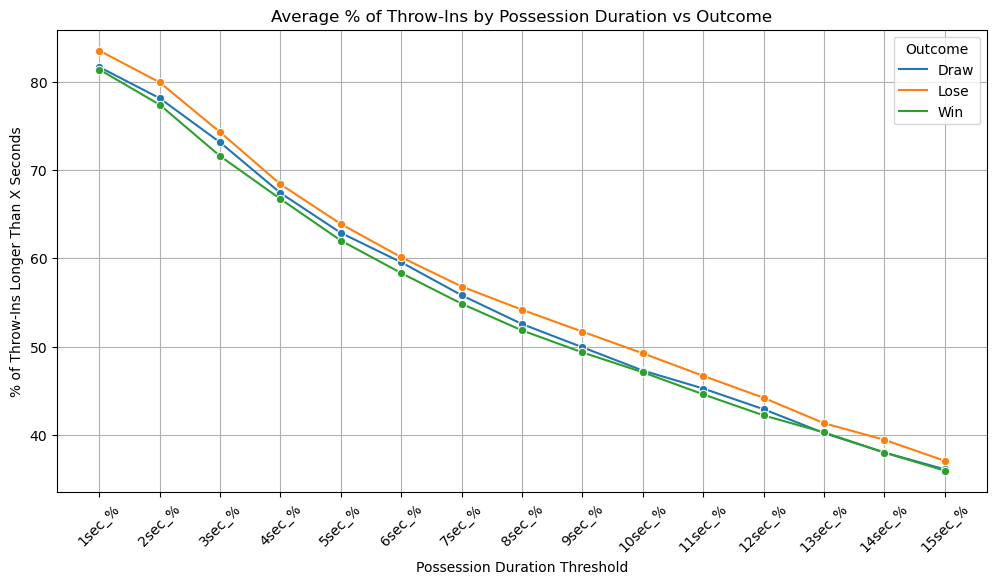

In [11]:
# Plotting for Games df to see if any obvious trends

# Filter only the % columns
percent_cols = [f'{i}sec_%' for i in range(1, 16)]

# Aggregate by Outcome
agg_df = Games.groupby('Outcome')[percent_cols].mean().reset_index()

# Melt for plotting
plot_df = agg_df.melt(id_vars='Outcome', var_name='Seconds', value_name='Percentage')

# Plot
plt.figure(figsize=(12,6))
sns.lineplot(data=plot_df, x='Seconds', y='Percentage', hue='Outcome', marker='o')
plt.xticks(rotation=45)
plt.title('Average % of Throw-Ins by Possession Duration vs Outcome')
plt.ylabel('% of Throw-Ins Longer Than X Seconds')
plt.xlabel('Possession Duration Threshold')
plt.grid(True)
plt.show()


In [12]:
# Remove columns only needed for feature engineering
Throws = Throws.drop(columns=['Location', 
                              'Outcome', 
                              'Possession_Time', 
                              'Match', 
                              'Team'
                              ])
Throws.head() # quick display

,Angle,Angle_Agg_Neutral,Angle_Agg_Safe,High_Throw,Length,LocationX,Right_Side,Third_Defensive,Third_Middle,Time_to_Throw,xRetain,xThrow
0,0.414244,1,0,1,-0.508686,0.767797,0,0,0,-0.361490,1,1
1,0.136194,0,0,0,0.187748,0.416949,0,0,1,0.266735,0,0
2,0.113517,0,0,1,-0.231802,0.246610,1,1,0,-0.445863,0,1
3,0.314578,0,0,0,0.788540,0.574576,0,0,1,-0.069378,1,1
4,0.365272,1,0,0,0.433361,0.640678,1,0,1,-0.638571,1,1


# Modeling
- Correlation matrix and class imbalance checks show nothing concerning for Angle_Agg, Third, and xRetain. No serious multicollinearity and the largest class was 40% of dataset for any of these.
- xThrow is heavily imbalanced, 82% of throws making it to their target. Specifically the xThrow model will need balancing before modeling.
- Two seperate models for xThrow and xRetain, then splitting data further into sub sections for Angle_Agg and Third. Hopefully this will show us some interesting insights.

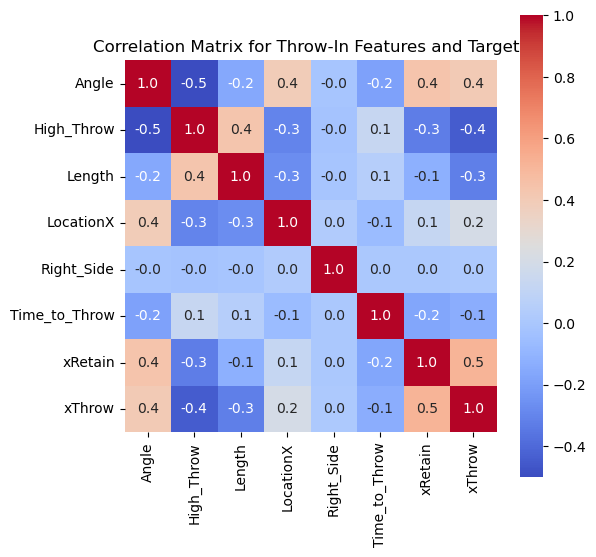

In [13]:
# Correlation Matrix
# None of the features are heavily correlated other than the targets themselves, which is good for modeling
plt.figure(figsize=(6, 6))
corr = Throws[['Angle', 
                      'High_Throw', 
                      'Length', 
                      'LocationX', 
                      'Right_Side',
                      'Time_to_Throw', 
                      'xRetain', 
                      'xThrow']].corr()
sns.heatmap(corr, annot=True, fmt=".1f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix for Throw-In Features and Targets')
plt.show()

In [14]:
# Class imbalance check for categorical features and target variables

# Angle_Agg
print(f"Angle_Agg")
print(f"Aggressive Count: {len(Throws)-Throws['Angle_Agg_Neutral'].sum()-Throws['Angle_Agg_Safe'].sum()}")
print(f"Neutral Count: {Throws['Angle_Agg_Neutral'].sum()}")
print(f"Safe Count: {Throws['Angle_Agg_Safe'].sum()}")

# Third
print(f"\nThird")
print(f"Attacking Third Count: {len(Throws)-Throws['Third_Middle'].sum()-Throws['Third_Defensive'].sum()}")
print(f"Middle Third Count: {Throws['Third_Middle'].sum()}")
print(f"Defensive Third Count: {Throws['Third_Defensive'].sum()}")

# xThrow
print(f"\nxThrow")
print(f"xThrow=1 Count: {Throws['xThrow'].sum()}")
print(f"xThrow=0 Count: {len(Throws)-Throws['xThrow'].sum()}")

# xRetain
print(f"\nxRetain")
print(f"xRetain=1 Count: {Throws['xRetain'].sum()}")
print(f"xRetain=0 Count: {len(Throws)-Throws['xRetain'].sum()}")


Angle_Agg
Aggressive Count: 7764
Neutral Count: 5125
Safe Count: 4468

Third
Attacking Third Count: 6420
Middle Third Count: 7108
Defensive Third Count: 3829

xThrow
xThrow=1 Count: 14316
xThrow=0 Count: 3041

xRetain
xRetain=1 Count: 9703
xRetain=0 Count: 7654


## xThrow Modeling
- Create seperate datasets to investigate throws in each third of the field individually to see if there are any trends
- Train/test split, will see if XGboost will deal with the imbalance without manual fixing
- First model: full dataset

In [15]:
# Seperate datasets for modeling for each third of field
Defensive = Throws[Throws['Third_Defensive'] == 1].reset_index(drop=True)
Middle = Throws[Throws['Third_Middle'] == 1].reset_index(drop=True)
Attacking = Throws[(Throws['Third_Defensive'] == 0) & (Throws['Third_Middle'] == 0)].reset_index(drop=True) 

## Defensive Third
print(
    f"Defensive Third Throws - Total: {len(Defensive)}"
    f"\nDefensive Third Throws - Safe: {len(Defensive[Defensive['Angle_Agg_Safe'] == 1])} - {len(Defensive[Defensive['Angle_Agg_Safe'] == 1]) / len(Defensive) * 100:.2f}%"
    f"\nDefensive Third Throws - Neutral: {len(Defensive[Defensive['Angle_Agg_Neutral'] == 1])} - {len(Defensive[Defensive['Angle_Agg_Neutral'] == 1]) / len(Defensive) * 100:.2f}%"
    f"\nDefensive Third Throws - Aggressive: {len(Defensive[(Defensive['Angle_Agg_Safe'] == 0) & (Defensive['Angle_Agg_Neutral'] == 0)])} - {len(Defensive[(Defensive['Angle_Agg_Safe'] == 0) & (Defensive['Angle_Agg_Neutral'] == 0)]) / len(Defensive) * 100:.2f}%"
)

## Middle Third
print(
    f"\nMiddle Third Throws - Total: {len(Middle)}"
    f"\nMiddle Third Throws - Safe: {len(Middle[Middle['Angle_Agg_Safe'] == 1])} - {len(Middle[Middle['Angle_Agg_Safe'] == 1]) / len(Middle) * 100:.2f}%"
    f"\nMiddle Third Throws - Neutral: {len(Middle[Middle['Angle_Agg_Neutral'] == 1])} - {len(Middle[Middle['Angle_Agg_Neutral'] == 1]) / len(Middle) * 100:.2f}%"
    f"\nMiddle Third Throws - Aggressive: {len(Middle[(Middle['Angle_Agg_Safe'] == 0) & (Middle['Angle_Agg_Neutral'] == 0)])} - {len(Middle[(Middle['Angle_Agg_Safe'] == 0) & (Middle['Angle_Agg_Neutral'] == 0)]) / len(Middle) * 100:.2f}%"
)

## Attacking Third
print(
    f"\nAttacking Third Throws - Total: {len(Attacking)}"
    f"\nAttacking Third Throws - Safe: {len(Attacking[Attacking['Angle_Agg_Safe'] == 1])} - {len(Attacking[Attacking['Angle_Agg_Safe'] == 1]) / len(Attacking) * 100:.2f}%"
    f"\nAttacking Third Throws - Neutral: {len(Attacking[Attacking['Angle_Agg_Neutral'] == 1])} - {len(Attacking[Attacking['Angle_Agg_Neutral'] == 1]) / len(Attacking) * 100:.2f}%"
    f"\nAttacking Third Throws - Aggressive: {len(Attacking[(Attacking['Angle_Agg_Safe'] == 0) & (Attacking['Angle_Agg_Neutral'] == 0)])} - {len(Attacking[(Attacking['Angle_Agg_Safe'] == 0) & (Attacking['Angle_Agg_Neutral'] == 0)]) / len(Attacking) * 100:.2f}%"
)

Defensive Third Throws - Total: 3829
Defensive Third Throws - Safe: 399 - 10.42%
Defensive Third Throws - Neutral: 677 - 17.68%
Defensive Third Throws - Aggressive: 2753 - 71.90%

Middle Third Throws - Total: 7108
Middle Third Throws - Safe: 1899 - 26.72%
Middle Third Throws - Neutral: 1751 - 24.63%
Middle Third Throws - Aggressive: 3458 - 48.65%

Attacking Third Throws - Total: 6420
Attacking Third Throws - Safe: 2170 - 33.80%
Attacking Third Throws - Neutral: 2697 - 42.01%
Attacking Third Throws - Aggressive: 1553 - 24.19%


In [16]:
Throws.head()

,Angle,Angle_Agg_Neutral,Angle_Agg_Safe,High_Throw,Length,LocationX,Right_Side,Third_Defensive,Third_Middle,Time_to_Throw,xRetain,xThrow
0,0.414244,1,0,1,-0.508686,0.767797,0,0,0,-0.361490,1,1
1,0.136194,0,0,0,0.187748,0.416949,0,0,1,0.266735,0,0
2,0.113517,0,0,1,-0.231802,0.246610,1,1,0,-0.445863,0,1
3,0.314578,0,0,0,0.788540,0.574576,0,0,1,-0.069378,1,1
4,0.365272,1,0,0,0.433361,0.640678,1,0,1,-0.638571,1,1


In [17]:
# Test train split for xThrow
from sklearn.model_selection import train_test_split
X = Throws.drop(columns=['xThrow', # target variable
                         'xRetain', # target variable
                         'Angle', # using binned version instead
                         'LocationX' # using binned version instead
                         ])
Y = Throws['xThrow']
X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                    test_size=0.2, 
                                                    random_state=19, 
                                                    stratify=Y # y_test will have same class imbalance as y_train
                                                    )

# Print lengths to confirm correct split
print(f"X_train: {len(X_train)}, X_test: {len(X_test)}")
print(f"y_train: {len(y_train)}, y_test: {len(y_test)}")
print(f"y_train class imbalance check: {y_train.value_counts()}")
print(f"\ny_test class imbalance check: {y_test.value_counts()}")

X_train: 13885, X_test: 3472
y_train: 13885, y_test: 3472
y_train class imbalance check: 1    11452
0     2433
Name: xThrow, dtype: int64

y_test class imbalance check: 1    2864
0     608
Name: xThrow, dtype: int64


In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

logreg = LogisticRegression(random_state=19, 
                            class_weight='balanced', # should help with imbalance 
                            solver='liblinear')


Fitting 3 folds for each of 729 candidates, totalling 2187 fits
Best Parameters: {'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'scale_pos_weight': 4.707661953304834, 'subsample': 0.7}
              precision    recall  f1-score   support

           0       0.77      0.05      0.10       608
           1       0.83      1.00      0.91      2864

    accuracy                           0.83      3472
   macro avg       0.80      0.53      0.50      3472
weighted avg       0.82      0.83      0.77      3472

Confusion Matrix:
 [[  33  575]
 [  10 2854]]


<Figure size 1000x600 with 0 Axes>

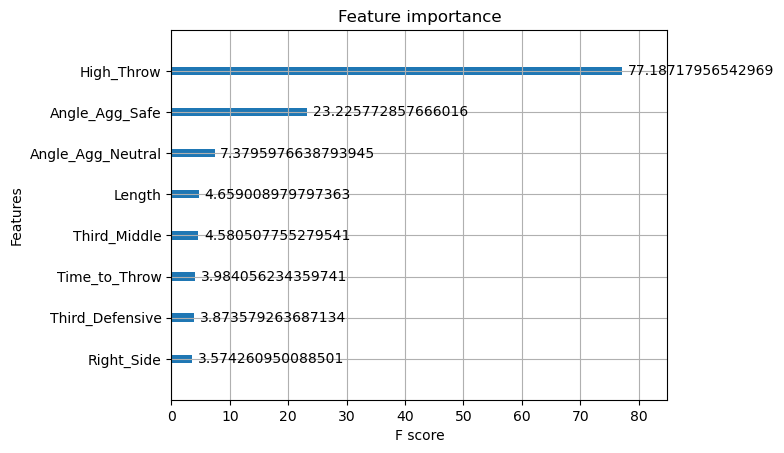

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import plot_importance
import matplotlib.pyplot as plt

# Base model
xgb = XGBClassifier(use_label_encoder=False, # avoids deprecation warning
                    eval_metric='logloss',  # standard for binary classification
                    random_state=42)

# Hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],       # Number of trees in the ensemble
    'max_depth': [3, 4, 5],                # Maximum depth of each tree
    'learning_rate': [0.01, 0.05, 0.1],    # Step size shrinkage (smaller = slower learning)
    'subsample': [0.7, 0.8, 1],            # Fraction of rows used per tree (prevents overfitting)
    'colsample_bytree': [0.7, 0.8, 1],     # Fraction of features used per tree (feature subsampling)
    'gamma': [0, 0.1, 0.2],                # Minimum loss reduction required to make a split
    'scale_pos_weight': [14316/3041]       # Handles class imbalance (majority/minority)
}

# Grid search with 3-fold CV
grid = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, scoring='f1', verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid.best_params_)

# Predict and evaluate
y_pred = grid.predict(X_test)
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Feature importance


plt.figure(figsize=(10,6))
plot_importance(grid.best_estimator_, max_num_features=10, importance_type='gain')
plt.show()
